In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

Can i write something which checks if it is stable? Say check the difference between the final two values say?  
have a feeling there will be an error some where. maybe the way i calculate the resistance shouldnt be for all. think about the C line.  
have worked out that it has to be under 3 delay with any alpha value.

#### data input

In [2]:
baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines.csv", index_col=0).rename(columns={"Q in single(m^3/s????)": "baseline Q"})


#### paramaters

In [3]:
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
n=1
max_time = 200
no = 101
delay_pressure_drop = 15

#### work out vectors

In [4]:
t = pd.Series(np.linspace(0,max_time,no))
dt = max_time/(no-1)

#### PRessure stuff
pressure_in = pd.Series(np.zeros(len(t)))
ratio_drop = 0.5
for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    else:
        pressure_in[i] = 60 - 34.18*ratio_drop
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out

## Model

#### Functions

In [5]:
def total_R(baselines,phi,alpha):
    C_ = alpha*(baselines.loc[6,'Resistance for Q']/2)/phi**4 + (1-alpha)*(baselines.loc[6,'Resistance for Q']/2)
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total

def euler(alpha,delay):
    delay_number = round(delay/dt)
    
    R_tot = pd.Series(np.zeros(len(t)))
    Q_tot = pd.Series(np.zeros(len(t)))
    Q_norm = pd.Series(np.ones(len(t)))
    
    phi = pd.Series(np.ones(no))
    phi_min = pd.Series(np.ones(no))
    dphidt = pd.Series(np.zeros(no))
    
    for i in range(len(t)):
        
        if i >=delay_number: 
            R_tot[i] = total_R(baselines,phi[i],alpha)
            Q_tot[i] = pressure_difference[i]/R_tot[i]
            Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
            dphidt[i] =  (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
            phi[i+1] = dphidt[i]*dt + phi[i]
            phi_min[i+1] = 1-(1-phi_min_baseline)*(1-Q_norm[i])**n
            
    combined = pd.DataFrame()
    combined['t'] = t
    combined['pressure_difference'] = pressure_difference
    combined['phi'] = phi
    combined['phi_min'] = phi_min
    combined['dphidt'] = dphidt
    combined['R_tot'] = R_tot
    combined['Q_tot'] = Q_tot
    combined['Q_norm'] = Q_norm
            
    return combined

#### the loop

In [6]:
response = {}
yay_or_nay = {}
num = 10
alpha = np.linspace(0,1,num=10)
delay = np.linspace(2.8,3.2, num=10)

# for i in range(len(alpha)):
#     for j in range(len(delay)):
#         #first is alpha second is delay
#         print('i', i,'j', j)
#         print(num-1-i,num-1-j,'-----')
#         response[num-1-i,num-1-j] = euler(alpha[num-1-i],delay[num-1-j])
#         if 
for i in range(len(alpha)):
    for j in range(len(delay)):
        #first is alpha second is delay
        response[i,j] = euler(alpha[i],delay[j])
        if len(response[i,j][response[i,j]['phi'] < 0]) == 0:
            yay_or_nay[i,j] = 1
        else:
            yay_or_nay[i,j] = 0

#### phi checker

#### graphs

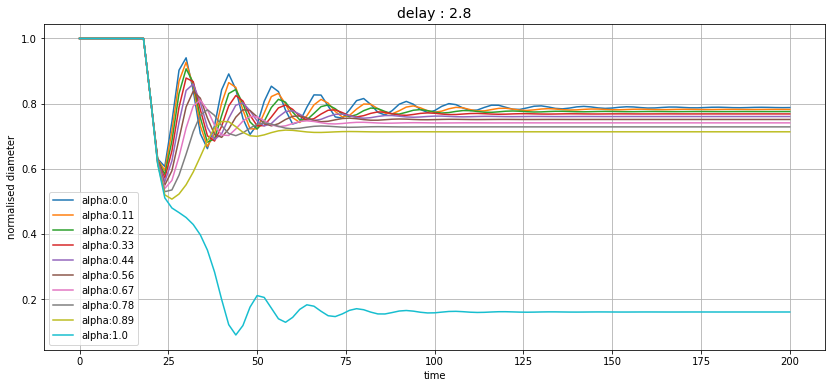

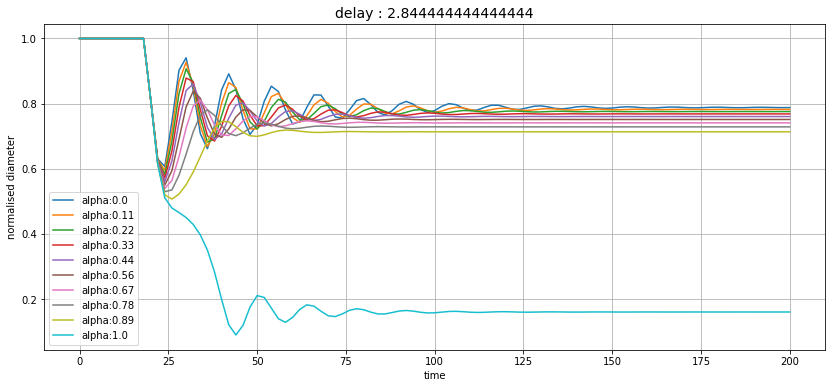

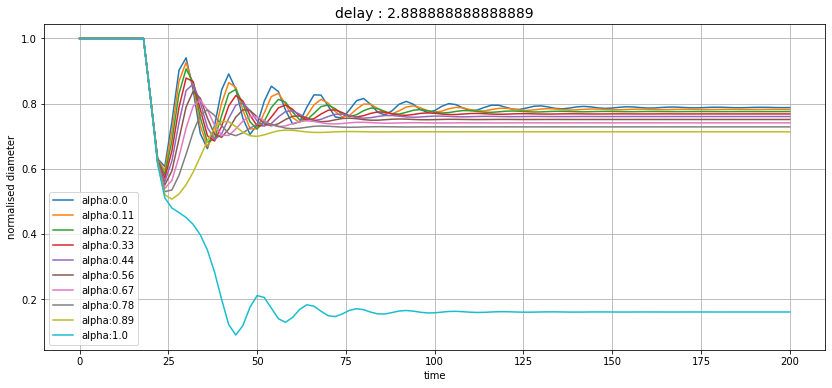

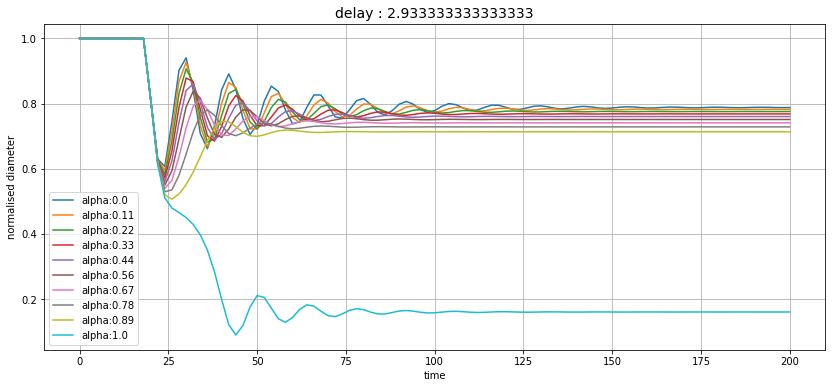

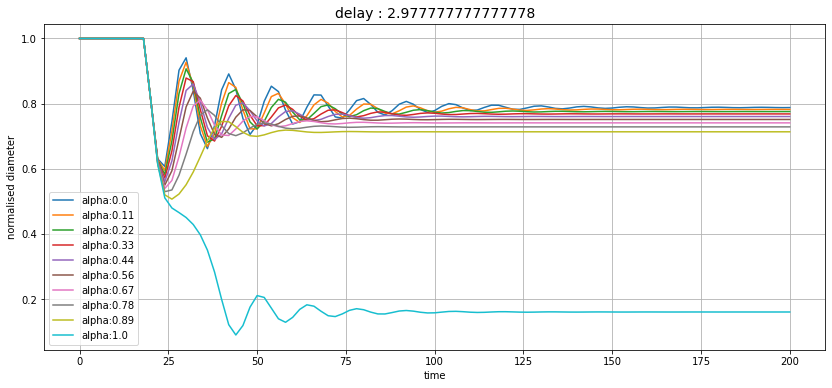

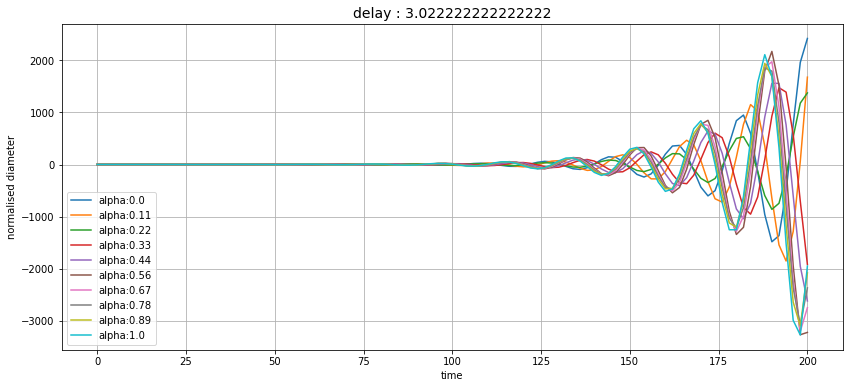

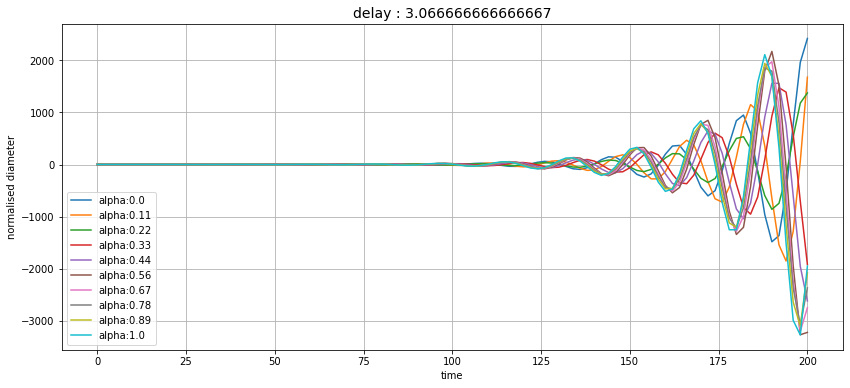

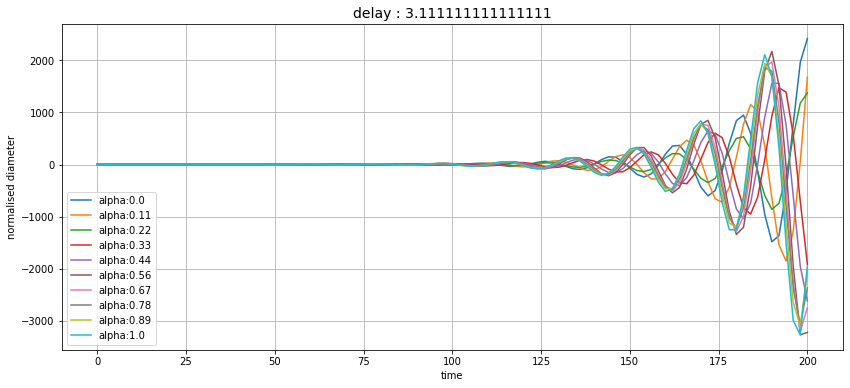

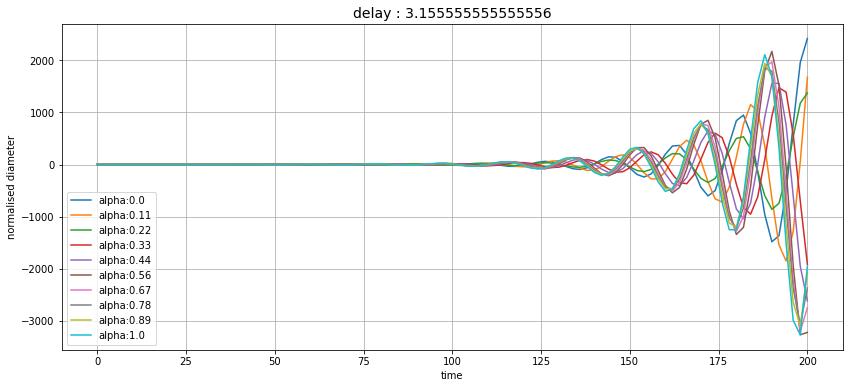

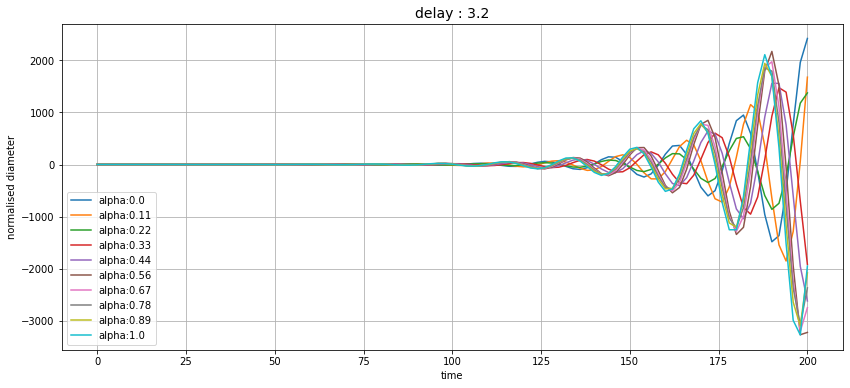

In [7]:
#set OPTION = 1 if want it to have a single value plot of delay with multiple alphas. 
#OPTION = 0 for single alpphas with multi delay
OPTION = 1

###Select which graphs
#put alpha in or delay in if you want the whole range
delay_graph = [0,1,2,3,4,5,6,7,8,9]
alpha_graph = [0,1,2,3,4,5,6,7,8,9]

fig = {}
ax = {}

if OPTION == 1 :
    for j in range(len(delay_graph)):
        fig[j],ax[j] = plt.subplots(figsize=(14,6))
        for i in range(len(alpha_graph)):
            ax[j] = plt.plot(response[alpha_graph[i],delay_graph[j]]['t'],response[alpha_graph[i],delay_graph[j]]['phi'][0:len(t)],label='alpha:{}' .format(round(alpha[alpha_graph[i]], ndigits=2)))
        fig[j] = plt.ylabel('normalised diameter')
        fig[j] = plt.xlabel('time')
        #ax[j] = plt.ylim(bottom=-0.5, top=1.5)
        fig[j] = plt.title('delay : {}' .format(delay[delay_graph[j]]), fontsize=14)
        fig[j] = plt.legend()
        fig[j] = plt.grid(which='both')
        
elif OPTION == 0 :
    for i in range(len(alpha_graph)):
        fig[i],ax[i] = plt.subplots(figsize=(14,6))
        for j in range(len(delay_graph)):
            ax[i] = plt.plot(response[alpha_graph[i],delay_graph[j]]['t'],response[alpha_graph[i],delay_graph[j]]['phi'][0:len(t)],label='delay:{}' .format(round(delay[delay_graph[j]], ndigits=4)))
        fig[i] = plt.ylabel('normalised diameter')
        fig[i] = plt.xlabel('time')
        ax[j] = plt.ylim(bottom=-0.5, top=1.5)
        fig[i] = plt.title('alpha : {}' .format(alpha[alpha_graph[i]]), fontsize=14)
        fig[i] = plt.legend()
        fig[i] = plt.grid(which='both')

In [8]:
len(response[9,9][response[9,9]['phi'] < 0])

41

In [9]:
len(response[0,0][response[0,0]['phi'] < 0])

0

In [10]:
delay[5]

3.022222222222222

In [11]:
response[0,4]['phi']

0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
         ...   
96     0.788699
97     0.788399
98     0.787865
99     0.787592
100    0.787785
Name: phi, Length: 101, dtype: float64

In [12]:
yay_or_nay

{(0, 0): 1,
 (0, 1): 1,
 (0, 2): 1,
 (0, 3): 1,
 (0, 4): 1,
 (0, 5): 0,
 (0, 6): 0,
 (0, 7): 0,
 (0, 8): 0,
 (0, 9): 0,
 (1, 0): 1,
 (1, 1): 1,
 (1, 2): 1,
 (1, 3): 1,
 (1, 4): 1,
 (1, 5): 0,
 (1, 6): 0,
 (1, 7): 0,
 (1, 8): 0,
 (1, 9): 0,
 (2, 0): 1,
 (2, 1): 1,
 (2, 2): 1,
 (2, 3): 1,
 (2, 4): 1,
 (2, 5): 0,
 (2, 6): 0,
 (2, 7): 0,
 (2, 8): 0,
 (2, 9): 0,
 (3, 0): 1,
 (3, 1): 1,
 (3, 2): 1,
 (3, 3): 1,
 (3, 4): 1,
 (3, 5): 0,
 (3, 6): 0,
 (3, 7): 0,
 (3, 8): 0,
 (3, 9): 0,
 (4, 0): 1,
 (4, 1): 1,
 (4, 2): 1,
 (4, 3): 1,
 (4, 4): 1,
 (4, 5): 0,
 (4, 6): 0,
 (4, 7): 0,
 (4, 8): 0,
 (4, 9): 0,
 (5, 0): 1,
 (5, 1): 1,
 (5, 2): 1,
 (5, 3): 1,
 (5, 4): 1,
 (5, 5): 0,
 (5, 6): 0,
 (5, 7): 0,
 (5, 8): 0,
 (5, 9): 0,
 (6, 0): 1,
 (6, 1): 1,
 (6, 2): 1,
 (6, 3): 1,
 (6, 4): 1,
 (6, 5): 0,
 (6, 6): 0,
 (6, 7): 0,
 (6, 8): 0,
 (6, 9): 0,
 (7, 0): 1,
 (7, 1): 1,
 (7, 2): 1,
 (7, 3): 1,
 (7, 4): 1,
 (7, 5): 0,
 (7, 6): 0,
 (7, 7): 0,
 (7, 8): 0,
 (7, 9): 0,
 (8, 0): 1,
 (8, 1): 1,
 (8, 2): 1,
 (8,

In [13]:
delay[9]

3.2

In [14]:
len(response[0,9][response[0,9]['phi'] < 0]) == 0

False